# Проект "Выбор локации для скважины"


**Описание проекта:**

**Заказчик проекта** - ГлавРосГосНефть. Ключевая потребность заказчика — нужно решить, где бурить новую скважину.

**Цель проекта**
- Построить модель для определения региона, где добыча принесёт наибольшую прибыль. 


**Источники данных:**
Данные геологоразведки трёх регионов находятся в файлах: 
/datasets/geo_data_0.csv. Скачать датасет
/datasets/geo_data_1.csv. Скачать датасет
/datasets/geo_data_2.csv. Скачать датасет
id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).


**План проекта:**

1. Загрузить и подготовить данные. Дополнительным шагом проведем EDA.

2. Обучить и проверить модель для каждого региона:
 2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
 2.2. Обучить модель и сделайте предсказания на валидационной выборке.
 2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
 2.4. Отразить средний запас предсказанного сырья и RMSE модели.
 2.5. Проанализировать результаты.
 
3. Подготовить данные к расчету прибыли
 3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
 3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
 3.3. Сформулировать выводы по этапу подготовки расчёта прибыли.
 
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 4.1. Выбрать скважины с максимальными значениями предсказаний. 
 4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
 4.3. Расчитать прибыль для полученного объёма сырья.
 
5. Посчитать риски и прибыль для каждого региона:
 5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 5.3. Сформулировать выводы: Предложить и обосновать регион для разработки скважин.
 
**Заданные ограничения:**

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка данных

### Импорт окружения

In [1]:
!pip install yellowbrick

In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade optuna

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install shap 

In [7]:
pip install scikit-learn==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import sklearn

from scipy import stats as st
from math import factorial
from scipy.stats import binom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder
)


from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    make_scorer
)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

from itertools import combinations
from scipy.spatial.distance import euclidean,cityblock

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 


import time
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [10]:
from sklearn.linear_model import Ridge

In [11]:
import shap

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
#Избавимся от экспонентного отображения формата данных в таблицах без фактического изменения формата
pd.set_option('display.float_format', '{:.2f}'.format)

### Загрузка источников данных

In [14]:
try:
    geo_data_zero = pd.read_csv('geo_data_0.csv', decimal=',')
except:
    geo_data_zero = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_0.csv',
        decimal=','
    )

In [15]:
geo_data_zero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [16]:
geo_data_zero.sample(5)

,id,f0,f1,f2,product
53012,LdStq,0.6289238797183085,0.6918565621974926,1.1885253373403613,137.6621420034259
19741,yG8ED,-0.8300696804500651,0.7033047300396346,1.5808592164824968,128.3152348774667
74240,0m29Y,0.4417057743572185,0.8943218058963773,-3.48123722486249,38.01719443746817
17492,rT9z2,1.9345062498558356,0.5236247720864242,-5.9558364878703784,29.83347559839925
42677,waAEB,0.17651580184584256,0.9127003940949804,3.1621317248493965,59.50082016895843


Признаки соответствуют описанию. Формат данных требует корректировки.

In [17]:
try:
    geo_data_one = pd.read_csv('geo_data_1.csv', decimal=',')
except:
    geo_data_one = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_1.csv',
        decimal=','
    )

In [18]:
geo_data_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [19]:
geo_data_one.sample(5)

,id,f0,f1,f2,product
34290,I735j,-10.17944875244385,-3.0970807520018147,5.003772364939524,137.94540774090564
79870,NHiBD,12.463661504481735,-0.33999335117630736,2.987822216842261,80.85978309461906
87725,PcK3t,0.3730611351898521,-10.005339255759964,2.001543048866195,53.90652206307938
11810,g60ua,-5.465668288151739,-3.7276103312416473,1.9942304643019808,57.08562464628662
1991,HJdIm,4.65298806879655,-7.042027986909523,4.992676785800164,137.94540774090564


Признаки соответствуют описанию. Формат данных требует корректировки.

In [20]:
try:
    geo_data_two = pd.read_csv('geo_data_2.csv', decimal=',')
except:
    geo_data_two = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_2.csv',
        decimal=','
    )

In [21]:
geo_data_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [22]:
geo_data_two.sample(5)

,id,f0,f1,f2,product
45044,Fyz4o,2.2013493443335266,1.9645329460956893,3.724393671361776,142.2197195610331
49889,6h4r7,-0.26110027102501016,-3.834345075966041,7.45073744998009,150.51221624433316
33258,LlVvD,2.623895228975459,0.5510153079389778,2.6025029784766804,63.01112083271405
6145,kvvWm,0.7180412233614041,-0.7815960281371145,0.5697357320062504,68.54051359815958
82003,ixlD9,-0.4238096617449533,0.12272317477410435,0.4593306945109698,61.77742221660948


Признаки соответствуют описанию. Формат данных требует корректировки.

## Предобработка данных

In [23]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    Параметры:
    df (pandas.DataFrame): DataFrame для проверки.
    
    Выводит:
    - информацию о DataFrame,
    - количество и распределение пропущенных значений,
    - количество явных дубликатов,
    - первые пять строк DataFrame.
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())

# Для получения документации функции использовать:
#help(check_df)

In [24]:
check_df(geo_data_zero)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,txEyH,0.7057449842080644,-0.4978225001976334,1.22116994843607,105.28006184349583
1,2acmU,1.3347112926051892,-0.3401642528583136,4.3650803324282,73.03775026515737
2,409Wp,1.0227322634721168,0.15199044457022945,1.4199262386740652,85.26564713099945
3,iJLyR,-0.03217162450743976,0.13903270818447744,2.9785659663204838,168.62077555509563
4,Xdl7t,1.988431059439699,0.15541267777667178,4.751769119262962,154.03664673738086


In [25]:
num_coll_list=['f0', 'f1', 'f2', 'product']

In [26]:
# Переведем значения признаков в формат float
for column in num_coll_list:
    geo_data_zero[column] = pd.to_numeric(geo_data_zero[column], errors='coerce')

In [27]:
check_df(geo_data_zero)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [28]:
geo_data_zero['id'].duplicated().sum()

10

In [29]:
geo_data_zero[geo_data_zero['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.76,0.37,1.86,30.68
1364,bxg6G,0.41,0.86,-3.65,73.60
1949,QcMuo,0.51,-0.32,-2.22,75.50
3389,A5aEY,-0.04,0.16,0.21,89.25
7530,HZww2,1.06,-0.37,10.43,158.83
16633,fiKDv,0.16,1.03,5.59,95.82
21426,Tdehs,0.83,0.30,-0.05,96.04
41724,bxg6G,-0.82,0.55,3.63,93.01
42529,AGS9W,1.45,-0.48,0.68,126.37
51970,A5aEY,-0.18,0.94,-2.09,33.02


В условиях проекта указано что id-уникальный идентификатор скважины. Наблюдаем что значения всех других признаков по 4м дублирующимся id  отличаются. Возможно, что это повторные наблюдения по той же самой скважине (например через промежуток времени, либо наблюдения, предоставленные другим исполнителем). В любом случае т.к. записи не являются полными дублями удалять не будем.

In [30]:
check_df(geo_data_one)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,kBEdx,-15.00134818249185,-8.275999947188001,-0.005876013693320655,3.179102583207246
1,62mP7,14.272087811011147,-3.47508321506002,0.9991827365665829,26.95326103153969
2,vyE1P,6.263187352448809,-5.948385788285711,5.001160160764809,134.76630515769844
3,KcrkZ,-13.081196289023516,-11.506056864519605,4.999414898074921,137.94540774090564
4,AHL4O,12.702194885533585,-8.147433374146587,5.00436255224226,134.76630515769844


In [31]:
# Переведем значения признаков в формат float
for column in num_coll_list:
    geo_data_one[column] = pd.to_numeric(geo_data_one[column], errors='coerce')

In [32]:
check_df(geo_data_one)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [33]:
geo_data_one.id.duplicated().sum()

4

In [34]:
geo_data_one[geo_data_one.id.duplicated(keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.17,-1.95,3.00,80.86
2721,bfPNe,-9.49,-5.46,4.01,110.99
5849,5ltQ6,-3.44,-12.30,2.00,57.09
41906,LHZR0,-8.99,-4.29,2.01,57.09
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82178,bfPNe,-6.20,-4.82,3.00,84.04
82873,wt4Uk,10.26,-9.38,4.99,134.77
84461,5ltQ6,18.21,2.19,3.99,107.81


In [35]:
check_df(geo_data_two)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       100000 non-null  object
 1   f0       100000 non-null  object
 2   f1       100000 non-null  object
 3   f2       100000 non-null  object
 4   product  100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,fwXo0,-1.1469870984179529,0.9633279217162892,-0.8289649221710994,27.758673230730036
1,WJtFt,0.2627779016539684,0.2698389572803021,-2.530186515492004,56.06969663239464
2,ovLUW,0.19458728165865746,0.2890350017576741,-5.586432770903118,62.87191004763475
3,q6cA6,2.2360596126935817,-0.5537598999099264,0.930037615920042,114.57284166750858
4,WPMUX,-0.5159928644136754,1.7162655596688288,5.899011469346728,149.60074591275887


In [36]:
# Переведем значения признаков в формат float
for column in num_coll_list:
    geo_data_two[column] = pd.to_numeric(geo_data_two[column], errors='coerce')

In [37]:
check_df(geo_data_two)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [38]:
# Проверим на наличие дубликатов в id
geo_data_two['id'].duplicated().sum()

4

In [39]:
geo_data_two[geo_data_two['id'].duplicated(keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.12,-0.86,5.75,181.72
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39
44378,Vcm5J,-1.23,-2.44,1.22,137.97
45404,KUPhW,0.23,-1.70,4.99,11.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
55967,KUPhW,1.21,3.18,5.54,132.83
95090,Vcm5J,2.59,1.99,2.48,92.33


В условиях проекта указано что id-уникальный идентификатор скважины. Наблюдаем что значения всех других признаков по 4м дублирующимся id  отличаются. Возможно, что это повторные наблюдения по той же самой скважине (например через промежуток времени, либо наблюдения, предоставленные другим исполнителем). В любом случае т.к. записи не являются полными дублями удалять не будем.

In [40]:
geo_data_two[geo_data_two['id'].duplicated()]

,id,f0,f1,f2,product
43233,xCHr8,-0.85,2.10,5.60,184.39
49564,VF7Jo,-0.88,0.56,0.72,136.23
55967,KUPhW,1.21,3.18,5.54,132.83
95090,Vcm5J,2.59,1.99,2.48,92.33


Итого по разделу:
1. Данные загружены, признаки и их значения соответствуют описанию
2. Датафреймы проверены на наличие явных дубликатов и пропусков
3. Типы данных приведены в соответствие.
4. Определены дубликаты по id

## Исследовательский анализ данных (доп раздел).  

### Статистический анализ

In [41]:
# Создадим функцию для визуализации диаграмм размаха.
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [42]:
# Создадим функцию для интерпретации стат данных.
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее
    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")

In [43]:
#Создадим функцию для построения диграмм размаха в разрезе числовых признаков
def num_coll_boxplot(df):
    num_coll_list = df.select_dtypes(include='number').columns.tolist()
    print('Стат анализ числовых признаков:', num_coll_list)
    for i in num_coll_list:
        box_plot_constuction = plot_boxplot(df, i)
        description = interpret_boxplot(df, i)
        describe = df[i].describe()
        print(box_plot_constuction)
        print(description)

In [44]:
#Создадим функцию для построения сводных таблиц в разрезе категориальных признаков
def cal_coll_pivot(df):
    cat_column_list = df.select_dtypes(exclude='number').columns.tolist()
    print('Анализ категориальных признаков:', cat_column_list)
    for i in cat_column_list:
        pivot_table = df.pivot_table(index=i, values='id', aggfunc='count', margins=True, margins_name='Итого')
        print(f"\nСводная таблица по признаку {i}:\n{pivot_table}\n")

Стат анализ числовых признаков: ['f0', 'f1', 'f2', 'product']


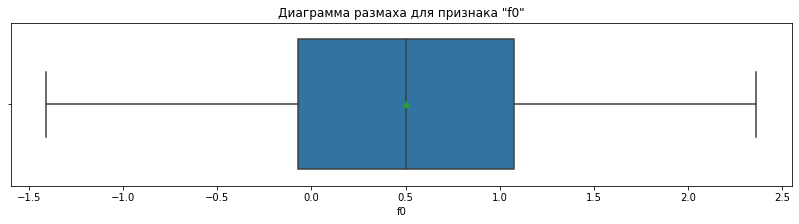

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'f0' - до -0.07258042446404508.
3. 50% значений 'f0' в диапазоне от -0.07258042446404508 до 1.073581404917224.
4. 25% значений 'f0' превышают 1.073581404917224.
5. Медиана 0.5
6. Среднее 0.5
None
None


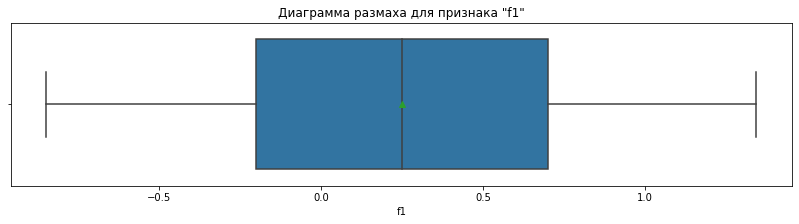

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'f1' - до -0.20088118576625755.
3. 50% значений 'f1' в диапазоне от -0.20088118576625755 до 0.7006464043880118.
4. 25% значений 'f1' превышают 0.7006464043880118.
5. Медиана 0.25
6. Среднее 0.25
None
None


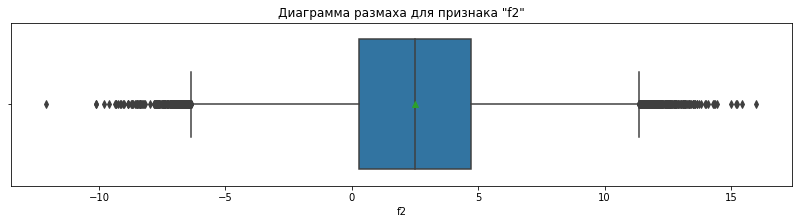

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f2' - до 0.28774815581444596.
3. 50% значений 'f2' в диапазоне от 0.28774815581444596 до 4.715087898413286.
4. 25% значений 'f2' превышают 4.715087898413286.
5. Медиана 2.52
6. Среднее 2.5
None
None


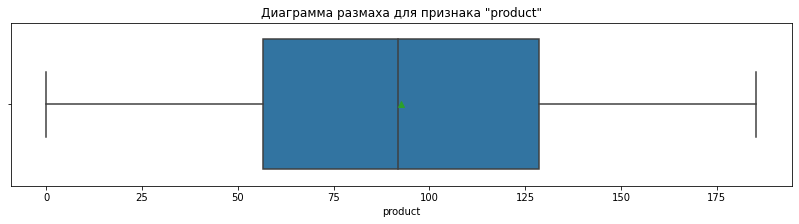

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'product' - до 56.49750665985803.
3. 50% значений 'product' в диапазоне от 56.49750665985803 до 128.56408897150277.
4. 25% значений 'product' превышают 128.56408897150277.
5. Медиана 91.85
6. Среднее 92.5
None
None


In [45]:
num_coll_boxplot(geo_data_zero)

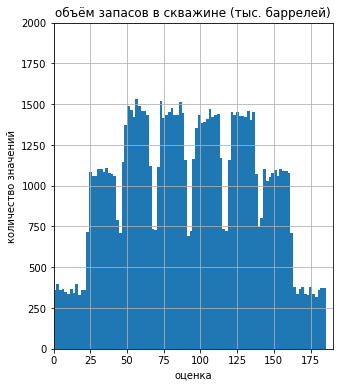

In [46]:
geo_data_zero.plot(y='product', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 2000), xlim=(0, 190), 
legend=False)
plt.title('объём запасов в скважине (тыс. баррелей)')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем мультимодальное распределение (5 пиков), Это может указывать на то, что запасы оцениваются в определенных «стандартных» диапазонах.

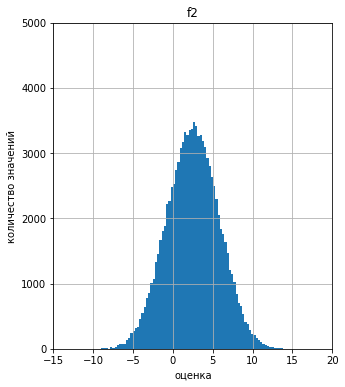

In [47]:
geo_data_zero.plot(y='f2', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 5000), xlim=(-15, 20), 
legend=False)
plt.title('f2')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

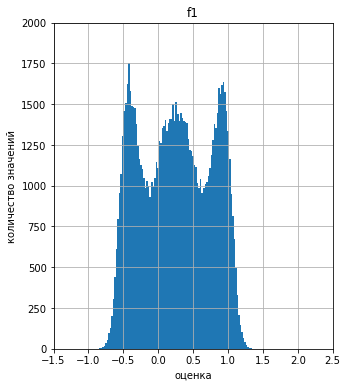

In [48]:
geo_data_zero.plot(y='f1', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 2000), xlim=(-1.5, 2.5), 
legend=False)
plt.title('f1')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем мультимодальное распределение (3 пика). Выглядит эпично ) 

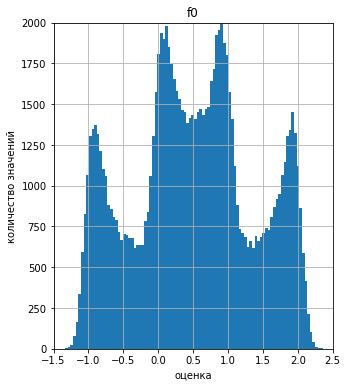

In [49]:
geo_data_zero.plot(y='f0', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 2000), xlim=(-1.5, 2.5), 
legend=False)
plt.title('f0')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем мультимодальное распределение (4 пика). 

Стат анализ числовых признаков: ['f0', 'f1', 'f2', 'product']


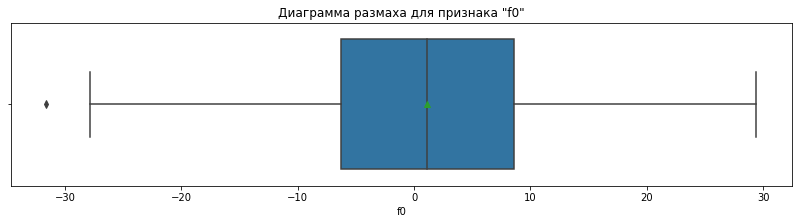

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f0' - до -6.298551155177497.
3. 50% значений 'f0' в диапазоне от -6.298551155177497 до 8.621015493890583.
4. 25% значений 'f0' превышают 8.621015493890583.
5. Медиана 1.15
6. Среднее 1.14
None
None


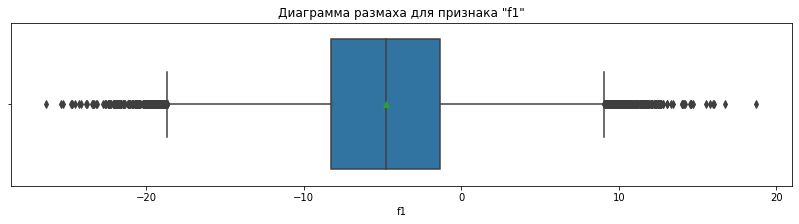

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f1' - до -8.26798483466915.
3. 50% значений 'f1' в диапазоне от -8.26798483466915 до -1.3328160113936642.
4. 25% значений 'f1' превышают -1.3328160113936642.
5. Медиана -4.81
6. Среднее -4.8
None
None


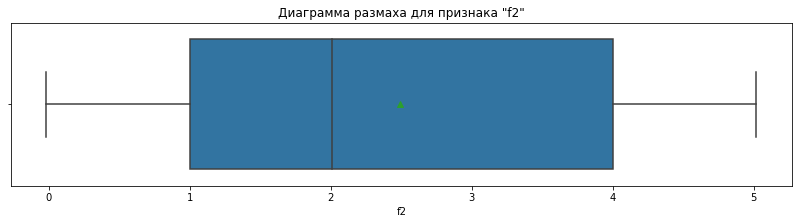

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'f2' - до 1.000021295032341.
3. 50% значений 'f2' в диапазоне от 1.000021295032341 до 3.9999040665177663.
4. 25% значений 'f2' превышают 3.9999040665177663.
5. Медиана 2.01
6. Среднее 2.49
None
None


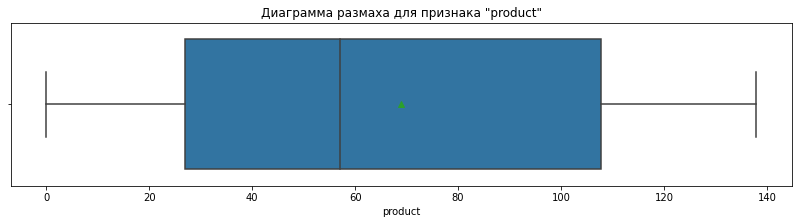

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'product' - до 26.95326103153969.
3. 50% значений 'product' в диапазоне от 26.95326103153969 до 107.81304412615876.
4. 25% значений 'product' превышают 107.81304412615876.
5. Медиана 57.09
6. Среднее 68.83
None
None


In [50]:
num_coll_boxplot(geo_data_one)

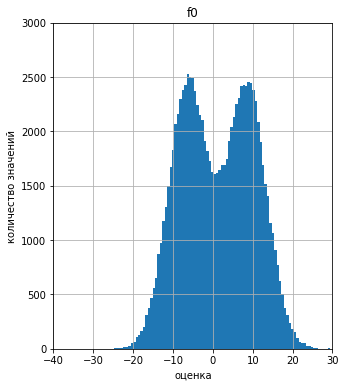

In [51]:
geo_data_one.plot(y='f0', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 3000), xlim=(-40, 30), 
legend=False)
plt.title('f0')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем бимодальное распределение

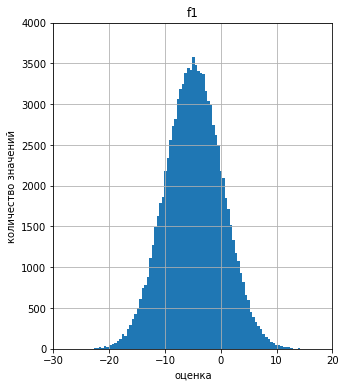

In [52]:
geo_data_one.plot(y='f1', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 4000), xlim=(-30, 20), 
legend=False)
plt.title('f1')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдает нормальное распределение.

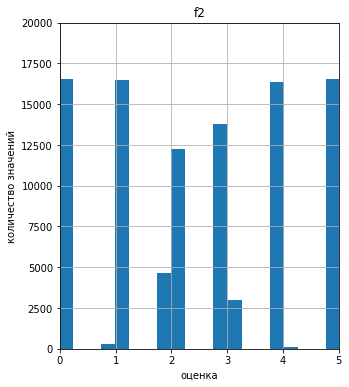

In [53]:
geo_data_one.plot(y='f2', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 20000), xlim=(0, 5), 
legend=False)
plt.title('f2')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем дискретные значения от 0 до 5 (вероятно категоризированные значения)

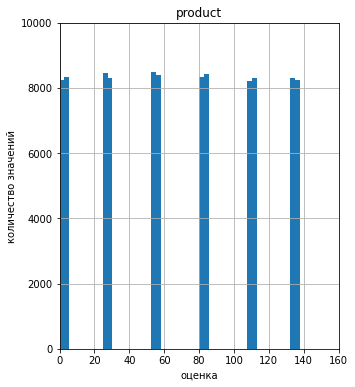

In [54]:
geo_data_one.plot(y='product', kind='hist', grid=True, figsize=(5, 6),
bins=50, ylim=(0, 10000), xlim=(0, 160), 
legend=False)
plt.title('product')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем 6 дискретных значений от 0 до 140 (вероятно категоризированные значения)

Стат анализ числовых признаков: ['f0', 'f1', 'f2', 'product']


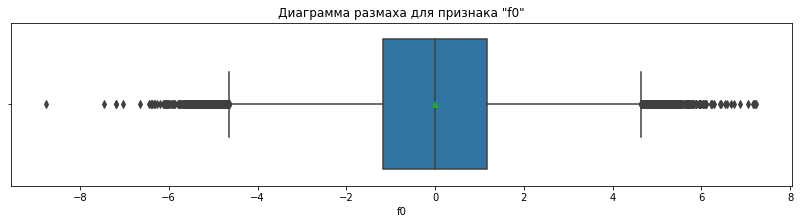

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f0' - до -1.1622884801574571.
3. 50% значений 'f0' в диапазоне от -1.1622884801574571 до 1.1585353487528773.
4. 25% значений 'f0' превышают 1.1585353487528773.
5. Медиана 0.01
6. Среднее 0.0
None
None


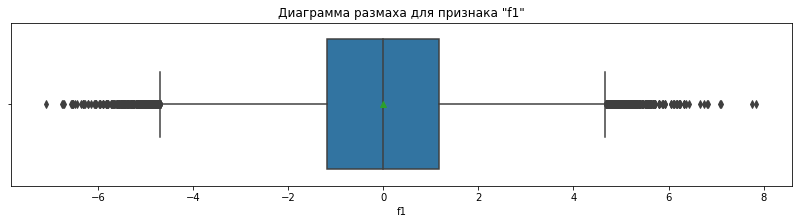

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f1' - до -1.174819610202934.
3. 50% значений 'f1' в диапазоне от -1.174819610202934 до 1.1636778666142238.
4. 25% значений 'f1' превышают 1.1636778666142238.
5. Медиана -0.01
6. Среднее -0.0
None
None


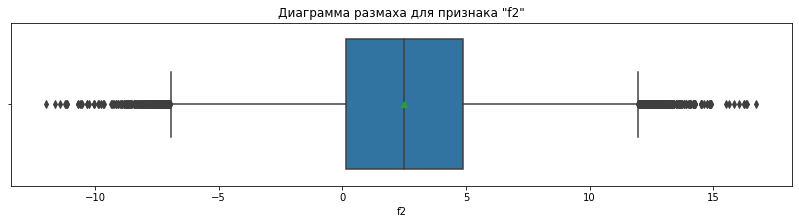

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'f2' - до 0.13035864392872082.
3. 50% значений 'f2' в диапазоне от 0.13035864392872082 до 4.85879359743347.
4. 25% значений 'f2' превышают 4.85879359743347.
5. Медиана 2.48
6. Среднее 2.5
None
None


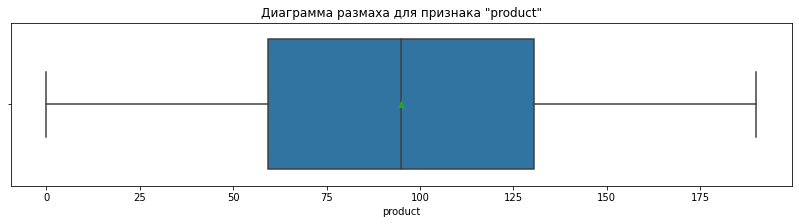

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'product' - до 59.45044093843895.
3. 50% значений 'product' в диапазоне от 59.45044093843895 до 130.5950267155838.
4. 25% значений 'product' превышают 130.5950267155838.
5. Медиана 94.93
6. Среднее 95.0
None
None


In [55]:
num_coll_boxplot(geo_data_two)

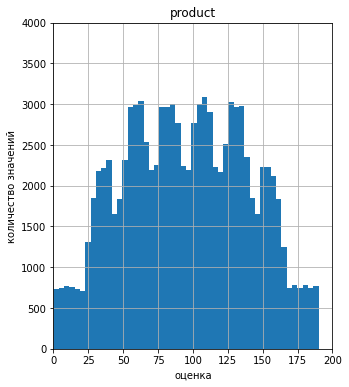

In [56]:
geo_data_two.plot(y='product', kind='hist', grid=True, figsize=(5, 6),
bins=50, ylim=(0, 4000), xlim=(0, 200), 
legend=False)
plt.title('product')
plt.ylabel('количество значений')
plt.xlabel('оценка')
plt.show()

Наблюдаем мультимодальное распередление - 6 пиков значений.

### Корреляционный анализ признаков

In [57]:
num_coll_list =  geo_data_zero.select_dtypes(include='number').columns.tolist()
cat_coll_list =  geo_data_zero.select_dtypes(exclude='number').columns.tolist()

Text(0.5, 1.0, 'Тепловая карта корреляции Пирсона')

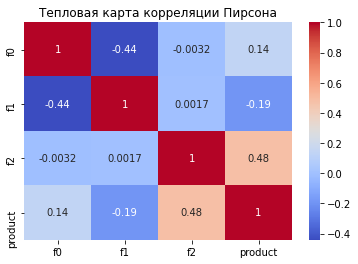

In [58]:
#Построим heatmap с корреляцией признаков
sns.heatmap(geo_data_zero[num_coll_list].corr(), annot=True, cmap='coolwarm') 
plt.title('Тепловая карта корреляции Пирсона')

Мультиколлинеарность между признаками отсутствует в geo_data_zero. Сильные и умеренные корреляции с целевым признаком отсутстуют. Незначительная корреляция с признаком f2. В виду того, что на прошлом шаге мы обнаружили выбивающиеся значения оценим корреляцию Спирмана

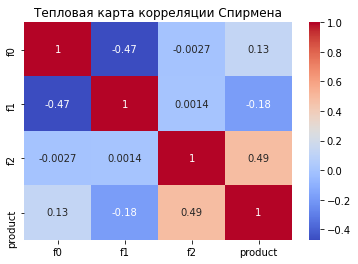

In [59]:
# Построим heatmap с корреляцией Спирмена 
sns.heatmap(geo_data_zero[num_coll_list].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Спирмена')
plt.show()

Картина повторилась

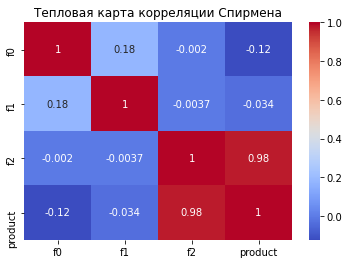

In [60]:
# Построим heatmap с корреляцией Спирмена 
sns.heatmap(geo_data_one[num_coll_list].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Спирмена')
plt.show()

Мультиколлинеарности между признаками нет. Наблюдаем сильную положительную корреляцию между целевым и f2 признаком в geo_data_one

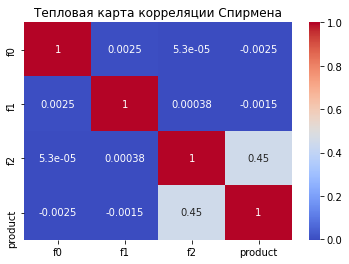

In [61]:
# Построим heatmap с корреляцией Спирмена 
sns.heatmap(geo_data_two[num_coll_list].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Спирмена')
plt.show()

Мультиколлинеарности между признаками нет. Наблюдаем слабую положительную корреляцию между целевым и f2 признаком в geo_data_two

In [62]:
# Создадим функцию для визуализации диаграмм рассеивания. 
# Мы в цикле вызываем все категориальные переменные для заданной пары числовых признаков. 

def plot_scatter(data, column_name_x, column_name_y):
        plt.figure(figsize=(4, 4))
        sns.scatterplot(data=data, x=column_name_x, y=column_name_y, alpha=0.6)
        plt.title(f' Анализ {column_name_y} - {column_name_x}')
        plt.ylabel(column_name_y)
        plt.xlabel(column_name_x)
        plt.legend(title=column_name_color, bbox_to_anchor=(1, 1), loc='upper left')
        plt.show()

Согласно условию проекта возможно использование линейной регрессии, что предполагает наличие только линейных зависимостей в данных. Пропустим шаг построения диаграмм рассеяния 

### Итого по разделу: 
  1. По датасету geo_data_zero: 
  
    1.1. Product. Наблюдаем мультимодальное распределение (5 пиков), Это может указывать на то, что запасы оцениваются в определенных «стандартных» диапазонах.
  
    1.2 Анонимизированные (обфусцированные) признаки имеют мультимодальные распределения. Значения признака f2 имеет правые и левые выбивающиеся значения.
   
  2. По датасету geo_data_one:
  
    2.1. Product. Наблюдаем дискретные значения от 0 до 140 (вероятно категоризированные значения).
    
    2.2. Фиксируем выбивающиеся значения для признаков f0 (левые) и f1 (левые и правые). Для признака f2 наблюдаем дискретные значения от 0 до 5 (вероятно категоризированные значения)
    
  3. По датасету geo_data_two:
  
    3.1. Product. Наблюдаем мультимодальное распередление - 5 пиков значений.
    3.2. Признаки f0, f1, f2 имеют выбивающиеся левые и правые выбивающие значения
    
 4. Мультиколлинеарности между признаками в данных нет. 
 
 5. Наблюдаем сильную положительную корреляцию между целевым и f2 признаком в geo_data_one, для остальных датасетов корреляция слабая.

## Создание моделей для каждого из регионов.

In [63]:
num_coll_list=['f0', 'f1', 'f2']

In [64]:
columns_to_drop=['id', 'product']

### Создание модели для для данных региона geo_data_zero

In [65]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    geo_data_zero.drop(columns_to_drop, axis=1
    ),
    geo_data_zero['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_coll_list)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_coll_list)
model_lr  = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
predictions = model_lr.predict(X_test_scaled)
rmse_scores = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
rmse_scores_val_zero = cross_val_score(model_lr, X_test_scaled, y_test, cv=5, scoring='neg_root_mean_squared_error').mean()

In [66]:
-rmse_scores

37.67200536313506

In [67]:
-rmse_scores_val_zero

37.75811155943487

In [68]:
# Посмотрим какие признаки наиблолее значимы для модели.
weights_v1 = pd.DataFrame({
    'Признак': X_train.columns,
    'Вес': model_lr.coef_
})

# Добавляем строку для свободного члена (intercept)
intercept_df = pd.DataFrame({
    'Признак': ['свободный_член'],
    'Вес': [model_lr.intercept_]
})

# Объединяем веса признаков и свободный член. На всякий случай обнуляем индексы при объединении. 
weights_v1 = pd.concat([weights_v1, intercept_df], ignore_index=True)

# Сортируем
weights_v1_sorted = weights_v1.sort_values(by='Вес', ascending=False)

# Выводим веса признаков и свободный член
print(weights_v1_sorted)

          Признак   Вес
3  свободный_член 92.56
2              f2 21.42
0              f0  3.34
1              f1 -7.18


Ожидаемо признак f2 имеет более высокий вес по сравнению с признаками f0, f1.

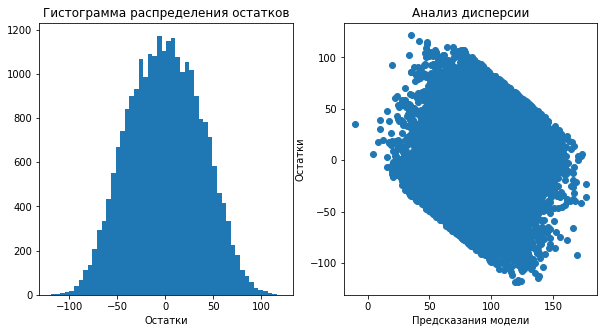

In [69]:
# Проводим анализ остатков
residuals = y_test-predictions

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

In [70]:
#запишем все прогнозы модели для валидационной выборки 
df_predict_zero = pd.DataFrame(predictions, columns=['predictions'], index=X_test.index)
print(df_predict_zero)

       predictions
75721       101.90
80184        78.22
19864       115.27
76699       105.62
92991        97.98
...            ...
21271       105.08
34014        74.77
81355        82.54
65720        81.83
11627        93.12

[25000 rows x 1 columns]


In [71]:
valid_data_zero=X_test.join(geo_data_zero[['id', 'product']])
valid_data_zero.sample(5)

,f0,f1,f2,id,product
58991,0.35,1.05,-0.15,ZTBzT,74.65
45051,0.14,1.22,-3.39,JdlF5,8.89
27093,1.13,-0.48,-2.17,w329j,29.44
20727,0.38,-0.36,3.53,9ga1h,88.39
79470,0.11,0.13,-0.17,1yb4i,170.67


In [72]:
#Создадим таблицу с валидационными данными geo_data_zero и прессказаниями модели
valid_data_zero=valid_data_zero.join(df_predict_zero['predictions'])
valid_data_zero.sample(5)

,f0,f1,f2,id,product,predictions
95507,1.79,0.22,-2.81,9YUVa,82.32,62.88
20196,1.92,0.02,2.66,fDkIp,161.27,102.22
46226,1.00,0.21,4.08,g4NZr,79.45,105.46
11471,1.61,-0.50,0.72,2VlxL,128.63,95.64
64151,-0.51,0.79,4.15,MJO46,90.90,91.89


### Создание модели для для данных региона geo_data_one

In [73]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    geo_data_one.drop(columns_to_drop, axis=1
    ),
    geo_data_one['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_coll_list)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_coll_list)
model_lr  = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
predictions = model_lr.predict(X_test_scaled)
rmse_scores = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
rmse_scores_val_one = cross_val_score(model_lr, X_test_scaled, y_test, cv=5, scoring='neg_root_mean_squared_error').mean()

In [74]:
-rmse_scores

0.8904559629285673

In [75]:
-rmse_scores_val_one

0.8901658757278078

In [76]:
# Посмотрим какие признаки наиблолее значимы для модели.
weights_v1 = pd.DataFrame({
    'Признак': X_train.columns,
    'Вес': model_lr.coef_
})

# Добавляем строку для свободного члена (intercept)
intercept_df = pd.DataFrame({
    'Признак': ['свободный_член'],
    'Вес': [model_lr.intercept_]
})

# Объединяем веса признаков и свободный член. На всякий случай обнуляем индексы при объединении. 
weights_v1 = pd.concat([weights_v1, intercept_df], ignore_index=True)

# Сортируем
weights_v1_sorted = weights_v1.sort_values(by='Вес', ascending=False)

# Выводим веса признаков и свободный член
print(weights_v1_sorted)

          Признак   Вес
3  свободный_член 68.86
2              f2 45.91
1              f1 -0.11
0              f0 -1.30


Ожидаемо признак f2 имеет более высокий вес по сравнению с признаками f0, f1.

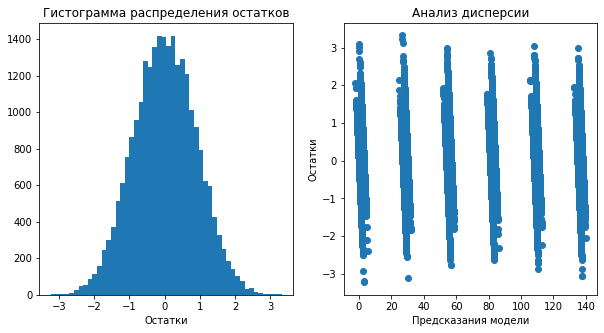

In [77]:
# Проводим анализ остатков
residuals = y_test-predictions

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

In [78]:
#запишем все прогнозы модели для валидационной выборки 
df_predict_one = pd.DataFrame(predictions, columns=['predictions'], index=X_test.index)
print(df_predict_one.sample(3))

       predictions
83875        54.25
88620        27.28
97181       136.12


In [79]:
valid_data_one=X_test.join(geo_data_one[['id', 'product']])
valid_data_one.sample(5)

,f0,f1,f2,id,product
32248,-9.99,-6.08,0.99,8o8dN,30.13
46609,-5.58,-8.98,1.00,2Q7GC,30.13
13340,14.24,-17.27,2.00,SeCwT,53.91
44909,-9.71,-8.72,3.00,QetWP,84.04
79964,-3.20,-2.31,3.00,uJ1V1,84.04


In [80]:
#Создадим таблицу с исходными значениями региона и предсказаниями
valid_data_one=valid_data_one.join(df_predict_one['predictions'])


In [81]:
valid_data_one.sample(3)

,f0,f1,f2,id,product,predictions
98583,-5.47,5.94,2.01,AowVQ,57.09,56.39
55370,11.18,-17.65,4.00,PS90L,107.81,108.18
83351,12.09,-8.01,4.00,txs8t,107.81,107.88


### Создание модели для для данных региона geo_data_two

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    geo_data_two.drop(columns_to_drop, axis=1
    ),
    geo_data_two['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_coll_list)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_coll_list)
model_lr  = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
predictions = model_lr.predict(X_test_scaled)
rmse_scores = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
rmse_scores_val_two = cross_val_score(model_lr, X_test_scaled, y_test, cv=5, scoring='neg_root_mean_squared_error').mean()

In [83]:
-rmse_scores

40.02698159997838

In [84]:
-rmse_scores_val_two

40.1537801191938

In [85]:
# Посмотрим какие признаки наиблолее значимы для модели.
weights_v1 = pd.DataFrame({
    'Признак': X_train.columns,
    'Вес': model_lr.coef_
})

# Добавляем строку для свободного члена (intercept)
intercept_df = pd.DataFrame({
    'Признак': ['свободный_член'],
    'Вес': [model_lr.intercept_]
})

# Объединяем веса признаков и свободный член. На всякий случай обнуляем индексы при объединении. 
weights_v1 = pd.concat([weights_v1, intercept_df], ignore_index=True)

# Сортируем
weights_v1_sorted = weights_v1.sort_values(by='Вес', ascending=False)

# Выводим веса признаков и свободный член
print(weights_v1_sorted)

          Признак   Вес
3  свободный_член 94.95
2              f2 19.99
1              f1 -0.03
0              f0 -0.15


Ожидаемо признак f2 имеет более высокий вес по сравнению с признаками f0, f1.

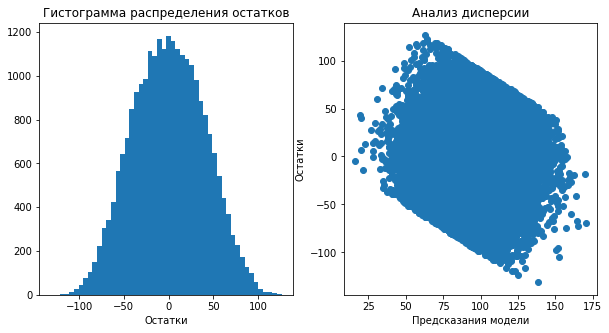

In [86]:
# Проводим анализ остатков
residuals = y_test-predictions

# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Центр распределения в районе нуля (ошибки предсказания модели симметричны). 

In [87]:
#запишем все прогнозы модели для валидационной выборки 
df_predict_two = pd.DataFrame(predictions, columns=['predictions'], index=X_test.index)
print(df_predict_two)

       predictions
75721        98.30
80184       101.59
19864        52.45
76699       109.92
92991        72.41
...            ...
21271       102.76
34014        93.43
81355        64.10
65720        83.76
11627        86.56

[25000 rows x 1 columns]


In [88]:
valid_data_two=X_test.join(geo_data_two[['id', 'product']])
valid_data_two.sample(3)

,f0,f1,f2,id,product
32364,2.11,-2.20,0.92,rVQ6P,149.62
59582,3.71,-0.35,5.10,FMz8J,66.94
68365,0.98,0.34,1.69,PX6PE,59.78


In [89]:
valid_data_two=valid_data_two.join(df_predict_two['predictions'])
valid_data_two.sample(3)

,f0,f1,f2,id,product,predictions
93282,1.29,1.02,6.08,lBSgM,127.26,115.38
19948,0.75,0.02,2.66,An0YQ,154.28,95.77
46272,-0.20,0.17,-1.65,Snqsb,124.97,71.09


### Расчет среднего запаса предсказанного сырья и RMSE модели

In [90]:
predict_means_zero=valid_data_zero.predictions.mean()
predict_means_one=valid_data_one.predictions.mean()
predict_means_two=valid_data_two.predictions.mean()
print(f'Среднее предсказание для региона geo_data_zero: {predict_means_zero}')
print(f'Среднее предсказание для региона geo_data_one: {predict_means_one}')
print(f'Среднее предсказание для региона geo_data_two: {predict_means_two}')
print(f'Качество модели (rmse) для geo_data_zero: {-rmse_scores_val_zero}')
print(f'Качество модели (rmse) для geo_data_one: {-rmse_scores_val_one}')
print(f'Качество модели (rmse) для geo_data_one: {-rmse_scores_val_two}')

Среднее предсказание для региона geo_data_zero: 92.39879990657768
Среднее предсказание для региона geo_data_one: 68.7128780391376
Среднее предсказание для региона geo_data_two: 94.77102387765939
Качество модели (rmse) для geo_data_zero: 37.75811155943487
Качество модели (rmse) для geo_data_one: 0.8901658757278078
Качество модели (rmse) для geo_data_one: 40.1537801191938


### Итоги раздела. Анализ результатов:

1. С учетом разного характера распределений входящих признаков, наличия дискретных значений целевых признаков. Для каждого датасета (3 региона) была обучена отдельная модель линейной регрессии, посчитаны метрики качества, проверен анализ весов признаков и остатков.
2. Проведен расчет среднего запаса 
3. Максимальное качество модели rmse наблюдаем на geo_data_one (0.8901658757278079)
4. Наибольшее среднее значение предсказанного запаса на валидационных данных в разрезе скважин наблюдаем на данных geo_data_two (94.77 тыс баррелей).

## Подготовка данных к расчету прибыли

In [91]:
# Создадим переменные для расчета себестоимости и прибыльности скважин и регионов

region_budget = 10000000000
income_per_burrel_th=450000
max_loss_probability=0.025
oil_well_for_exploration=500
amount_of_top_oil_well=200

In [92]:
#Рассчитаем достаточный объём сырья для безубыточной разработки для 1 новой скважины. 
min_explored_reserve=region_budget/amount_of_top_oil_well/income_per_burrel_th
min_explored_reserve

111.11111111111111

In [93]:
#Посчитаем разницу между минимальным для достижения уровня безубыточности объемом нефти и средним объем скважин в регионе

delta_zero = predict_means_zero-min_explored_reserve
delta_one = predict_means_one-min_explored_reserve
delta_two = predict_means_two-min_explored_reserve

In [94]:
#Посчитаем среднее значение запасов для ТОП200 каждого из регионов.
top_zero=valid_data_zero.nlargest(200, 'predictions')
top_zero_mean=top_zero['predictions'].mean()
top_one=valid_data_one.nlargest(200, 'predictions')
top_one_mean=top_one['predictions'].mean()
top_two=valid_data_two.nlargest(200, 'predictions')
top_two_mean=top_two['predictions'].mean()

In [95]:
#Посчитаем разницу между минимальным для достижения уровня безубыточности объемом нефти и средних предсказанных обьемов ТОП 200 скважин 
# для каждого региона
delta_top_zero = top_zero_mean-min_explored_reserve
delta_top_one = top_one_mean-min_explored_reserve
delta_top_two = top_two_mean-min_explored_reserve

### Выводы по итогам раздела

Полученное значение минимального запаса скважины для достижения безубыточности значительно превышает средние значения по всем 3 регионам (особенно по региону one). При этом, заданная методология предполагает отбор топ 200 лучших скважин для разработки, для которых среднее значение исследованных запасов выше минимального объема в каждом регионе. 

In [96]:
print(f'для региона zero: {delta_zero}')
print(f'для региона one: {delta_one}')
print(f'для региона two: {delta_two}')

для региона zero: -18.712311204533435
для региона one: -42.39823307197351
для региона two: -16.340087233451726


In [97]:
print(f'Среднее ТОП 200 для региона zero: {delta_top_zero}')
print(f'Среднее ТОП 200 для региона one: {delta_top_one}')
print(f'Среднее ТОП 200 для региона two: {delta_top_two}')

Среднее ТОП 200 для региона zero: 43.29620532962386
Среднее ТОП 200 для региона one: 27.632645722212004
Среднее ТОП 200 для региона two: 37.53312793016613


## Создание функции для расчета прибыли в регионе

In [98]:
# Создадим функцию для расчета прибыли в регионе с учетом заданного числа скважин
def profit(predicts, product, count):
    pred_sorted = predicts.sort_values(ascending=False)
    selected = product[pred_sorted.index][:count] 
    return income_per_burrel_th *selected.sum()-region_budget 

In [99]:
#Применим функцию для расчета прибыли в регионах по заданным условиям (Разрабатываются 200 скважит, расходы 10 млрд руб.)
profit_zero=profit(valid_data_zero['predictions'],valid_data_zero['product'], amount_of_top_oil_well)
profit_one=profit(valid_data_one['predictions'],valid_data_one['product'], amount_of_top_oil_well)
profit_two=profit(valid_data_two['predictions'],valid_data_two['product'], amount_of_top_oil_well)

print(f'Прибыль от объёма сырья в регионе zero: {profit_zero.round(2)}')
print(f'Прибыль от объёма сырья в регионе one: {profit_one.round(2)}')
print(f'Прибыль от объёма сырья в регионе two: {profit_two.round(2)}')

Прибыль от объёма сырья в регионе zero: 3359141114.46
Прибыль от объёма сырья в регионе one: 2415086696.68
Прибыль от объёма сырья в регионе two: 2598571759.37


### Итого по разделу:
1. Создана функция для расчета прибыли региона с учетом разработки 200 скважин и предсказанных ранее значений исследованных запасов.
2. Расчитан прогноз прибыли для каждого из регионов с учетом того, что максимальные расходы на разработку 200 выбранных месторождений региона составляют 10 млрд руб. По итогам прогноза наибольная прибыль достигается в регионе zero.
- Прибыль для предсказанного объёма сырья в регионе zero: 3.359 млрд руб. 
- Прибыль для предсказанного объёма сырья в регионе one: 2.415 млрд руб.
- Прибыль для предсказанного объёма сырья в регионе two: 2.598 млрд руб.

## Расчет рисков и прибыли для каждого региона

In [100]:
valid_data_zero.shape[0]

25000

In [101]:
#Расчитаем среднюю прибыль региона и дов интервалы с использованием бутстрапа для региона zero.
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    pred_subsample  = valid_data_zero['predictions'].sample(
        frac=oil_well_for_exploration/valid_data_zero.shape[0],
        replace=True, random_state=state
    )
    fact_subsample = valid_data_zero['product'][pred_subsample.index] 
    values.append(profit(pred_subsample, fact_subsample,  200))
   

values_zero = pd.Series(values)
lower = values_zero.quantile(0.025)
upper = values_zero.quantile(0.975)

mean_zero = values_zero.mean()
print("Средняя прибыль:", mean_zero)
print("2.25й-квантиль:", lower)
print("97.75й-квантиль:", upper)

Средняя прибыль: 435933772.1386621
2.25й-квантиль: -116231612.77720818
97.75й-квантиль: 966504180.707376


In [102]:
#Посчитаем вероятность получения убытков исходя из текущего распределения средних прибылей для региона zero
negative_count_zero=(values_zero < 0).sum()
negative_count_zero
prob_of_losses=negative_count_zero/len(values_zero)
print(f'вероятность получения убытков для региона zero равен {prob_of_losses}')

вероятность получения убытков для региона zero равен 0.061



<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подсчета доверительного интервала использовался именно метод квантилей!
</div>


<div class="alert alert-block alert-info">

<b>Совет: </b> Риск можно было найти чуть проще: `(values < 0).mean()`, если объект типа pandas Series или numpy array.
</div>

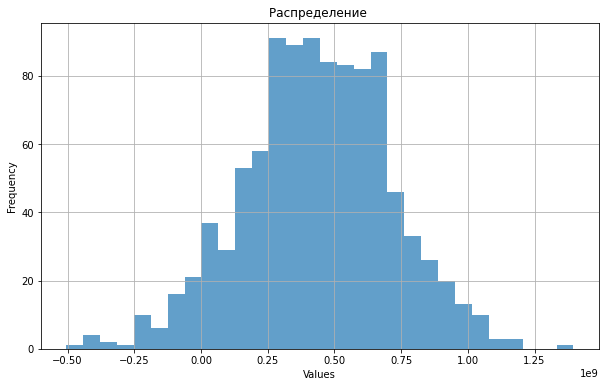

In [103]:
# Построим распределение средних для региона zero чтобы визуально подтвердить результат.
plt.figure(figsize=(10,6))
values_zero.plot(kind='hist', bins=30, alpha=0.7)
plt.title('Распределение ')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [104]:
#Расчитаем среднюю прибыль региона и дов интервалы с использованием бутстрапа для региона one.
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    pred_subsample  = valid_data_one['predictions'].sample(
        frac=oil_well_for_exploration/valid_data_one.shape[0],
        replace=True, random_state=state
    )
    fact_subsample = valid_data_one['product'][pred_subsample.index] 
    values.append(profit(pred_subsample, fact_subsample,  200))
   
values_one = pd.Series(values)
lower = values_one.quantile(0.025)
upper = values_one.quantile(0.975)

mean_one = values_one.mean()
print("Средняя прибыль:", mean_one)
print("2.25й-квантиль:", lower)
print("97.75й-квантиль:", upper)

Средняя прибыль: 489661254.41175246
2.25й-квантиль: 55116177.27361494
97.75й-квантиль: 905762650.4248402


In [105]:
#Посчитаем вероятность получения убытков исходя из текущего распределения средних прибылей для региона one
negative_count_one=(values_one < 0).sum()
negative_count_one
prob_of_losses=negative_count_one/len(values_one)
print(f'вероятность получения убытков для региона one равен {prob_of_losses}')

вероятность получения убытков для региона one равен 0.011


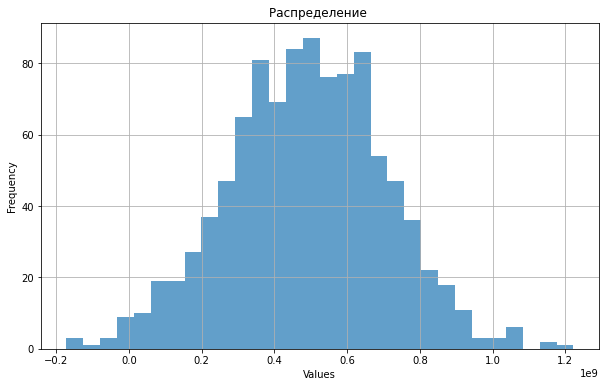

In [106]:
# Построим распределение средних для региона one чтобы визуально подтвердить результат.
plt.figure(figsize=(10,6))
values_one.plot(kind='hist', bins=30, alpha=0.7)
plt.title('Распределение ')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [107]:
#Расчитаем среднюю прибыль и дов интервалы с использованием бутстрапа для региона two.
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    pred_subsample  = valid_data_two['predictions'].sample(
        frac=oil_well_for_exploration/valid_data_two.shape[0],
        replace=True, random_state=state
    )
    fact_subsample = valid_data_two['product'][pred_subsample.index] 
    values.append(profit(pred_subsample, fact_subsample,  200))
   
values_two = pd.Series(values)
lower = values_two.quantile(0.025)
upper = values_two.quantile(0.975)

mean_two = values_two.mean()
print("Средняя прибыль:", mean_two)
print("2.25й-квантиль:", lower)
print("97.75й-квантиль:", upper)

Средняя прибыль: 403687927.86213845
2.25й-квантиль: -153116984.7619049
97.75й-квантиль: 952887416.7078604


In [108]:
#Посчитаем вероятность получения убытков исходя из текущего распределения средних прибылей для региона two
negative_count_two=(values_two < 0).sum()
negative_count_two
prob_of_losses=negative_count_two/len(values_two)
print(f'вероятность получения убытков для региона two равна {prob_of_losses}')

вероятность получения убытков для региона two равна 0.071


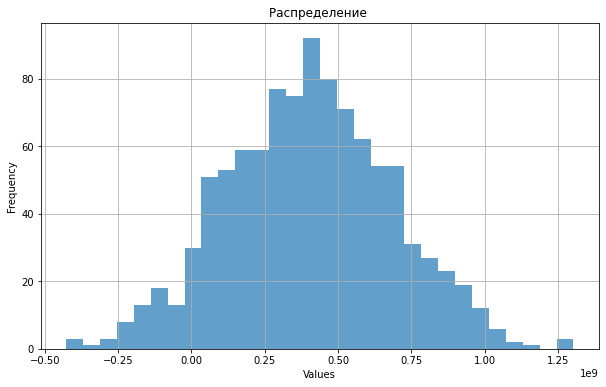

In [109]:
# Построим распределение средних для региона two чтобы визуально подтвердить результат.

plt.figure(figsize=(10,6))
values_two.plot(kind='hist', bins=30, alpha=0.7)
plt.title('Распределение ')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Итого по разделу:

1. Проверен расчет средней прибыли (распределение средних) и дов интервалы для каждого региона с использованием бутстрапа.

2. По итогам расчета получены следующие значения:

2.1. По региону Zero: 
Средняя прибыль: 435933772.1386621
2.25й-квантиль: -116231612.77720818
97.75й-квантиль: 966504180.707376
- вероятность получения убытков для региона zero равна 0.061
2.1. По региону One:
Средняя прибыль: 489661254.41175246
2.25й-квантиль: 55116177.27361494
97.75й-квантиль: 905762650.4248402
- вероятность получения убытков для региона zero равна 0.011

2.2 По региону Two:
Средняя прибыль: 403687927.86213845
2.25й-квантиль: -153116984.7619049
97.75й-квантиль: 952887416.7078604
- вероятность получения убытков для региона zero равна 0.071

3. Выводы:
- Исходя из распределения средних наибольшим потенциалом обладает регион One, наименьним регион Two.
- Под требования проекта (вероятность убытков меньше 2.5%) подходит только регион One (1.1%)

С учетом расчитанных значений прибыли и допустимой вероятности риска убытков предлагаем выбрать для разработки  регион One.

Таблица с ключевыми расчетами в проекте:
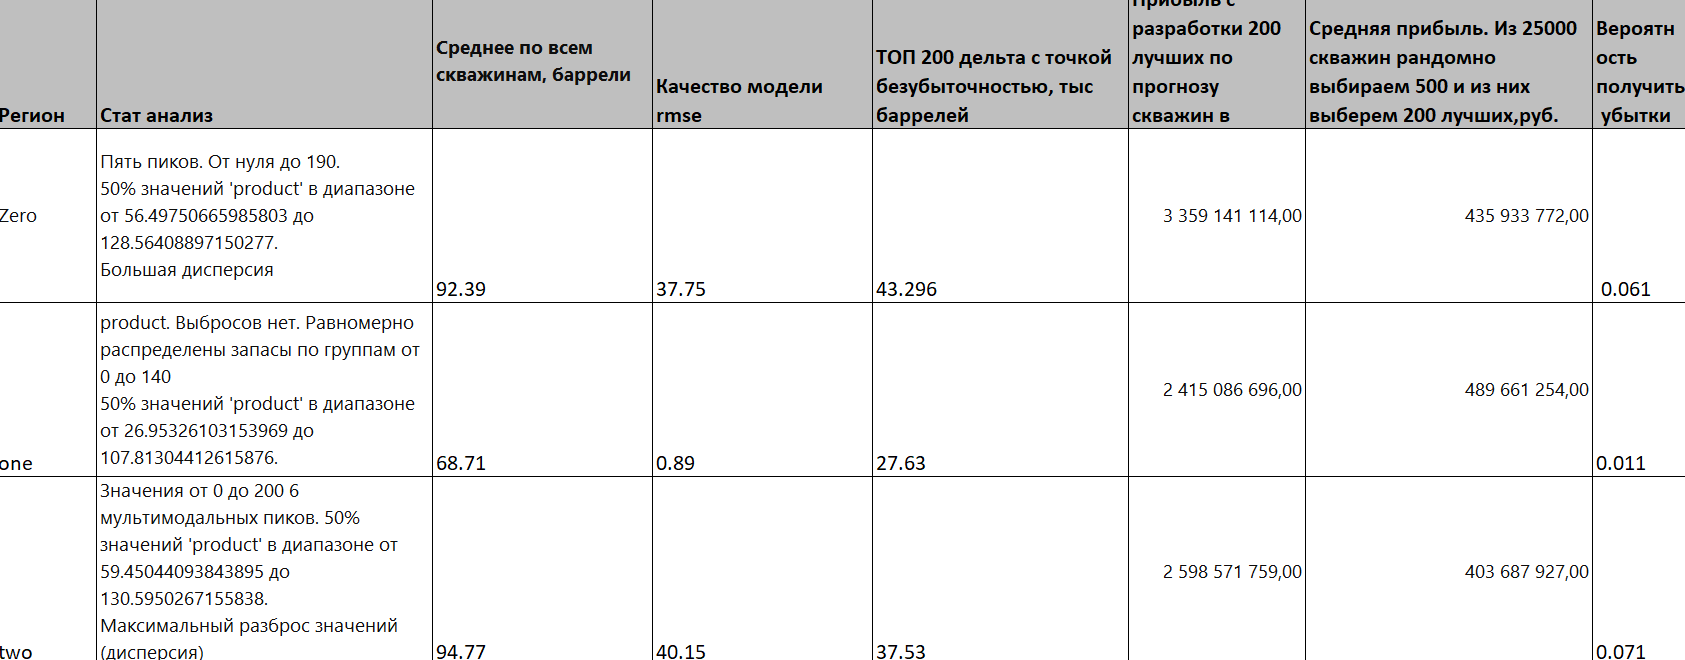

## Общий вывод по проекту: 
   1. Загружены и проведены данные.
   
   2. Проведена предобработка. Датафреймы проверены на наличие явных дубликатов и пропусков. Типы данных приведены в соответствие. 
   
   3. Проведен исследовательский анализ данных. Проведен корреляционный анализ признаков.
   
   4. С учетом разного характера распределений входящих признаков, наличия дискретных значений целевых признаков. Для каждого датасета (3 региона) была обучена отдельная модель линейной регрессии, посчитаны метрики качества, проверен анализ весов признаков и остатков. Проведен расчет среднего запаса.
   - Максимальное качество модели rmse наблюдаем на geo_data_one (0.8901658757278079).
   - Наибольшее среднее значение предсказанного запаса на валидационных данных в разрезе скважин наблюдаем на данных geo_data_two
   
   5. Расчитано значение минимального запаса скважины для достижения безубыточности. Полученное значение значительно превышает средние значения по всем 3 регионам (особенно по региону one). При этом, заданная методология предполагает отбор топ 200 лучших скважин для разработки, для которых среднее значение исследованных запасов выше минимального объема в каждом регионе.
   
   6. Создана функция для расчета прибыли региона с учетом разработки 200 скважин и предсказанных ранее значений исследованных запасов. Расчитан прогноз прибыли для каждого из регионов с учетом того, что максимальные расходы на разработку 200 выбранных месторождений региона составляют 10 млрд руб. По итогам прогноза наибольная прибыль достигается в регионе zero.
- Прибыль для предсказанного объёма сырья в регионе zero: 3.359 млрд руб. 
- Прибыль для предсказанного объёма сырья в регионе one: 2.415 млрд руб.
- Прибыль для предсказанного объёма сырья в регионе two: 2.598 млрд руб.
 
 
   7. Проверен расчет средней прибыли (распределение средних) и дов интервалы для каждого региона с использованием бутстрапа.
   По итогам расчета получены следующие значения:
   
    7.1 По региону Zero: 
    Средняя прибыль: 435933772.1386621
    2.25й-квантиль: -116231612.77720818
    97.75й-квантиль: 966504180.707376
    - вероятность получения убытков для региона zero равна 0.061
    7.2. По региону One:
    Средняя прибыль: 489661254.41175246
    2.25й-квантиль: 55116177.27361494
    97.75й-квантиль: 905762650.4248402
    - вероятность получения убытков для региона zero равна 0.011

    7.3 По региону Two:
    Средняя прибыль: 403687927.86213845
    2.25й-квантиль: -153116984.7619049
    97.75й-квантиль: 952887416.7078604
    - вероятность получения убытков для региона zero равна 0.071
    

   8. Итоговый вывод:
    - Исходя из распределения средних наибольшим потенциалом обладает регион One, наименьним регион Two.
    - Под требования проекта (вероятность убытков меньше 2.5%) подходит только регион One (1.1%)


## Сырой контент

In [110]:
# Создадим шаг для замены пропущенных значений числовых признаков медианой.
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

In [111]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_coll_list),
    ], 
    remainder='passthrough'
)

In [112]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ])

In [113]:
param_distributions = [
    # словарь для модели Ridge()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [114]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error',     
    random_state=RANDOM_STATE,
    n_iter=50,
    cv=5,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [115]:
best_model = randomized_search.best_estimator_['models']
best_model

LinearRegression()

In [116]:
print('Метрика rmse для лучшей модели на кроссвалидации:\n', -randomized_search.best_score_)
print(randomized_search.best_params_)

Метрика rmse для лучшей модели на кроссвалидации:
 40.02698159997838
{'preprocessor__num': StandardScaler(), 'models': LinearRegression()}


In [117]:
best_model.coef_

array([-0.14567612, -0.02677615, 19.98791624])

In [118]:
# Теперь мы можем получить веса признаков и свободный член
weights = best_model.coef_  
intercept = best_model.intercept_

# Достаем названия признаков
feature_names_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Создаем датафрейм с весами признаков
weights_df = pd.DataFrame({
    'Признак': feature_names_transformed,
    'Вес': weights
})

# Добавляем строку для свободного члена (intercept)
intercept_df = pd.DataFrame({
    'Признак': ['свободный_член'],
    'Вес': intercept
})

# Объединяем веса признаков и свободный член.
weights_df = pd.concat([weights_df, intercept_df], ignore_index=True)

# Сортируем по весу
weights_df_sorted = weights_df.sort_values(by='Вес', ascending=False)

# Выводим веса признаков и свободный член
print(weights_df_sorted)

          Признак   Вес
3  свободный_член 94.95
2         num__f2 19.99
1         num__f1 -0.03
0         num__f0 -0.15


param_distributions = [
    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]